In [1]:
import zipfile
zipfile.ZipFile('data_files.zip').extractall()

In [2]:
import imageio as iio
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import pandas as pd
import numpy as np
import random


directory = "poke_photos/"
pokemon_names = []
pokemon_photos = []
# pil = []

In [3]:
# for filename in os.listdir(directory):
#     # Stores names of each pokemon
#     name = os.path.splitext(filename)[0]
#     pokemon_names.append(name)
#     # Stores the images of each pokemon - matrix representation
#     im = iio.imread(directory + filename)
#     im = im.resize((120,120))
#     pokemon_photos.append(im)

In [4]:
for filename in os.listdir(directory):
    # Stores names of each pokemon
    name = os.path.splitext(filename)[0]
    pokemon_names.append(name)
    # Stores the images of each pokemon - matrix representation
    im = mping.imread(directory + filename)

    pokemon_photos.append(im)

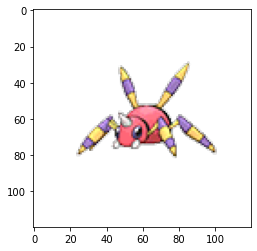

In [5]:
plt.imshow(pokemon_photos[0])

In [6]:
# Data Frame with corresponding names and image matrix
images = pd.DataFrame(columns = ('Name', 'Image_Mat'))
images['Name'] = pokemon_names
images['Image_Mat'] = pokemon_photos
# images['PIL'] = pil

# Sort based on names and reset index
images = images.sort_values("Name", ascending = True).reset_index(drop = True)
images

,Name,Image_Mat
0,abomasnow,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
1,abra,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
2,absol,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
3,accelgor,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
4,aegislash-blade,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
...,...,...
804,zoroark,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
805,zorua,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
806,zubat,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
807,zweilous,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."


In [7]:
# Pokemon info data set
pokemon_data = pd.read_csv('pokemon_to_photos.csv')
pokemon_data = pokemon_data.sort_values("Name", ascending = True).reset_index(drop = True)

pokemon_data

,Name,Type1,Type2
0,abomasnow,Grass,Ice
1,abra,Psychic,NaN
2,absol,Dark,NaN
3,accelgor,Bug,NaN
4,aegislash-blade,Steel,Ghost
...,...,...,...
804,zoroark,Dark,NaN
805,zorua,Dark,NaN
806,zubat,Poison,Flying
807,zweilous,Dark,Dragon


In [8]:
# Combined the two datasets
pokemon_data['Image_Mat'] = images['Image_Mat']
pokemon_data

,Name,Type1,Type2,Image_Mat
0,abomasnow,Grass,Ice,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
1,abra,Psychic,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
2,absol,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
3,accelgor,Bug,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
4,aegislash-blade,Steel,Ghost,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
...,...,...,...,...
804,zoroark,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
805,zorua,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
806,zubat,Poison,Flying,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."
807,zweilous,Dark,Dragon,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ..."


In [9]:
# To view the image of the pokemon
def view_pokemon(val) :
    print("Pokemon: " + pokemon_data['Name'][val])
    plt.imshow(pokemon_data['Image_Mat'][val])

# view_pokemon(0)

Pokemon: tentacool


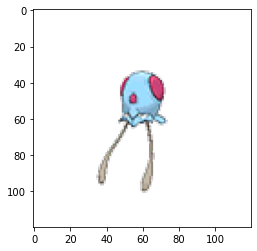

In [10]:
# Each image has a height/width of 120 and a dimension of 4
# image size: 57600
# max RGB value: 255
# min RBG valeue: 0

# print(pokemon_data['Image_Mat'][0])
# print(pokemon_data['Image_Mat'][1].min())
# print(pokemon_data['Image_Mat'][2].max())
# print(pokemon_data['Image_Mat'][3].shape)
# print(pokemon_data['Image_Mat'][4].shape)
pokemon_data['Image_Mat'][9].shape
view_pokemon(700)

## TESTING

In [11]:
# https://www.geeksforgeeks.org/extract-dominant-colors-of-an-image-using-python/
import math

avg_color = []

for pokemon in pokemon_data['Image_Mat']:
    # Stores all RGB values and resets for each pokemon
    r = []
    g = []
    b = []
    # Case for RGB-A or 4 dimension
    if (pokemon.shape == (120,120,4)):
        for row in pokemon:
            for temp_r, temp_g, temp_b,temp in row:
                # Not taking into account black pixels
                if ((int(temp_r) + int(temp_g) + int(temp_b)) != 0):
                    r.append(temp_r)
                    g.append(temp_g)
                    b.append(temp_b)
        avg_color.append([math.floor(np.mean(r)), math.floor(np.mean(g)), math.floor(np.mean(b))])
        
    # Case for RGB or 3 dimension
    else:
        for row in pokemon:
            for temp_r, temp_g, temp_b in row:
                # Not taking into account black pixels
                if ((int(temp_r) + int(temp_g) + int(temp_b)) != 0):
                    r.append(temp_r)
                    g.append(temp_g)
                    b.append(temp_b)
        avg_color.append([math.floor(np.mean(r)), math.floor(np.mean(g)), math.floor(np.mean(b))])
    
avg_color
pokemon_data['avg_color'] = avg_color

In [12]:
pokemon_data

,Name,Type1,Type2,Image_Mat,avg_color
0,abomasnow,Grass,Ice,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
1,abra,Psychic,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
2,absol,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
3,accelgor,Bug,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
4,aegislash-blade,Steel,Ghost,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
...,...,...,...,...,...
804,zoroark,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
805,zorua,Dark,NaN,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"
806,zubat,Poison,Flying,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[1, 0, 0]"
807,zweilous,Dark,Dragon,"[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...","[0, 0, 0]"


In [13]:
learn_data = pokemon_data.copy(deep = True)


In [14]:
learn_data = learn_data.drop(columns = ['Name', 'Type2', 'Image_Mat'])

In [15]:
learn_data

,Type1,avg_color
0,Grass,"[0, 0, 0]"
1,Psychic,"[0, 0, 0]"
2,Dark,"[0, 0, 0]"
3,Bug,"[0, 0, 0]"
4,Steel,"[0, 0, 0]"
...,...,...
804,Dark,"[0, 0, 0]"
805,Dark,"[0, 0, 0]"
806,Poison,"[1, 0, 0]"
807,Dark,"[0, 0, 0]"


In [16]:
pca_data = learn_data.copy(deep = True)
pca_data

,Type1,avg_color
0,Grass,"[0, 0, 0]"
1,Psychic,"[0, 0, 0]"
2,Dark,"[0, 0, 0]"
3,Bug,"[0, 0, 0]"
4,Steel,"[0, 0, 0]"
...,...,...
804,Dark,"[0, 0, 0]"
805,Dark,"[0, 0, 0]"
806,Poison,"[1, 0, 0]"
807,Dark,"[0, 0, 0]"


In [17]:
value_count = learn_data['Type1'].value_counts()
unique = value_count.index.to_list()
value_count, unique

(Water       114
 Normal      105
 Grass        78
 Bug          72
 Fire         53
 Psychic      53
 Rock         46
 Electric     40
 Poison       34
 Ground       32
 Dark         29
 Fighting     29
 Dragon       27
 Ghost        27
 Steel        26
 Ice          23
 Fairy        18
 Flying        3
 Name: Type1, dtype: int64,
 ['Water',
  'Normal',
  'Grass',
  'Bug',
  'Fire',
  'Psychic',
  'Rock',
  'Electric',
  'Poison',
  'Ground',
  'Dark',
  'Fighting',
  'Dragon',
  'Ghost',
  'Steel',
  'Ice',
  'Fairy',
  'Flying'])

In [18]:
# unique_types = list(learn_data['Type1'].unique())
# unique_types

In [19]:
# unique_count = [i for i in range(18)]

In [20]:
# dict(zip(unique_types, unique_count))

In [21]:
# learn_data['Type1'].replace(dict(zip(unique_types, unique_count)), inplace = True)

In [22]:
learn_data

,Type1,avg_color
0,Grass,"[0, 0, 0]"
1,Psychic,"[0, 0, 0]"
2,Dark,"[0, 0, 0]"
3,Bug,"[0, 0, 0]"
4,Steel,"[0, 0, 0]"
...,...,...
804,Dark,"[0, 0, 0]"
805,Dark,"[0, 0, 0]"
806,Poison,"[1, 0, 0]"
807,Dark,"[0, 0, 0]"


In [23]:
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split

In [24]:
Y = learn_data['Type1'].to_list()

In [25]:
X = learn_data['avg_color'].to_list()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.33, random_state = 42)

In [27]:
model = tree.DecisionTreeClassifier()

In [28]:
model = model.fit(X_train, y_train)

In [29]:
model

DecisionTreeClassifier()

In [30]:
test_poke = pd.DataFrame(list(zip(y_test, X_test)), columns = ['Type1','avg_color'])
test_poke

,Type1,avg_color
0,Normal,"[0, 0, 0]"
1,Electric,"[0, 0, 0]"
2,Grass,"[0, 0, 0]"
3,Grass,"[245, 244, 239]"
4,Water,"[0, 0, 0]"
...,...,...
262,Normal,"[0, 0, 0]"
263,Normal,"[0, 0, 0]"
264,Normal,"[0, 0, 0]"
265,Ground,"[0, 0, 0]"


In [31]:
poison = model.predict([[165, 144, 118]])

In [32]:
poison

array(['Psychic'], dtype='<U8')

In [33]:
subset = test_poke[test_poke['Type1'] == unique[10]]

In [34]:
subset

,Type1,avg_color
13,Dark,"[0, 0, 0]"
19,Dark,"[0, 0, 0]"
66,Dark,"[0, 0, 0]"
72,Dark,"[0, 0, 0]"
73,Dark,"[0, 0, 0]"
101,Dark,"[0, 0, 0]"
120,Dark,"[167, 177, 175]"
153,Dark,"[0, 0, 0]"
191,Dark,"[0, 0, 0]"
225,Dark,"[0, 0, 0]"


In [35]:
subset_size = subset.shape[0]
subset_size

12

In [36]:
subset_avg = subset['avg_color'].to_list()
subset_avg

[[0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [167, 177, 175],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

In [37]:
preds = []
for i in subset_avg:
    preds.append(model.predict([i]))

In [38]:
preds

[array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Psychic'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8'),
 array(['Water'], dtype='<U8')]

In [39]:
accuracy = len([i[0] for i in preds if i == unique[10]]) / subset_size
accuracy

0.0

In [40]:
#pca

In [41]:
pca_data

,Type1,avg_color
0,Grass,"[0, 0, 0]"
1,Psychic,"[0, 0, 0]"
2,Dark,"[0, 0, 0]"
3,Bug,"[0, 0, 0]"
4,Steel,"[0, 0, 0]"
...,...,...
804,Dark,"[0, 0, 0]"
805,Dark,"[0, 0, 0]"
806,Poison,"[1, 0, 0]"
807,Dark,"[0, 0, 0]"


In [42]:
avg_rgb = pd.DataFrame(pca_data['avg_color'].to_list(), columns = ['avg_r', 'avg_g', 'avg_b'])
pca_data = pd.concat([pca_data, avg_rgb], axis=1)
pca_data = pca_data.drop('avg_color', axis=1)

In [43]:
pca_data 
# if this grows in columns run the deep copy again and run above again

,Type1,avg_r,avg_g,avg_b
0,Grass,0,0,0
1,Psychic,0,0,0
2,Dark,0,0,0
3,Bug,0,0,0
4,Steel,0,0,0
...,...,...,...,...
804,Dark,0,0,0
805,Dark,0,0,0
806,Poison,1,0,0
807,Dark,0,0,0


In [44]:
pca_data['Type1']=pd.Categorical(pca_data['Type1'])
my_color=pca_data['Type1'].cat.codes

X = pca_data.drop(columns = ['Type1'])
X.head()

,avg_r,avg_g,avg_b
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [45]:
Y = np.array(pca_data['Type1'])
Y[:10]

array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Steel',
       'Normal', 'Psychic', 'Water'], dtype=object)

In [46]:
pca_data['Type1'].value_counts()

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Type1, dtype: int64

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler(with_mean = False)
scaler.fit(X)
X_standardized = scaler.transform(X)
X_standard = pd.DataFrame(X_standardized, columns = X.columns)

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components = 3, random_state = 0)
pca.fit(X_standardized)
X_dim_reducted = pca.transform(X_standardized)
X_dim_reducted
result = pd.DataFrame(X_dim_reducted, columns = ['PCA1','PCA2','PCA3'])

In [51]:
legend = dict(zip())
legend

{}

In [52]:
import matplotlib

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

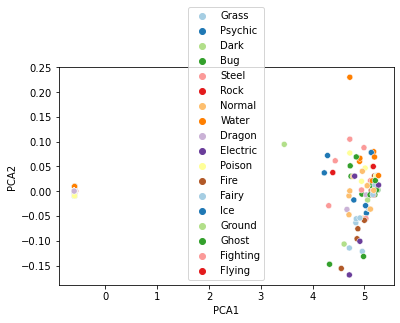

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components = 3)

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = Y, palette = "Paired", data = result) 


<Figure size 480x480 with 0 Axes>

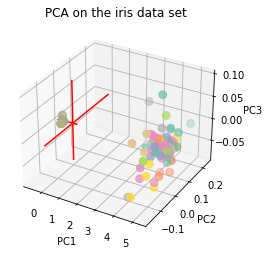

In [56]:
%matplotlib inline
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA1'], result['PCA2'], result['PCA3'], c=my_color, cmap="Set2_r", s=60)

xAxisLine = ((min(result['PCA1']), max(result['PCA2'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA2']), max(result['PCA2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA3']), max(result['PCA3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the iris data set")
plt.show()